In [1]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('youth_smoking_drug_data_10000_rows_expanded.csv')

print("Dataset Overview:")
print(data.head())


Dataset Overview:
   Year Age_Group  Gender  Smoking_Prevalence  Drug_Experimentation  \
0  2024     15-19    Both               18.85                 32.40   
1  2024     10-14  Female               34.88                 41.57   
2  2023     10-14    Both               42.00                 56.80   
3  2024     40-49    Both               33.75                 42.90   
4  2023     15-19    Male               47.90                 39.62   

  Socioeconomic_Status  Peer_Influence School_Programs  Family_Background  \
0                 High               5             Yes                  1   
1                 High               6             Yes                 10   
2                 High               6             Yes                  2   
3               Middle              10              No                  9   
4                 High               1              No                  2   

   Mental_Health Access_to_Counseling  Parental_Supervision  \
0              5             

In [2]:
print("The Initial Shape of the Dataset:", data.shape)


The Initial Shape of the Dataset: (10000, 15)


In [3]:
class Sigmoid:
    def forward(self,x):
        # Computed the sigmoind function
        # The result is stored in self.output for use during the backward pass
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, grad):
        return grad * self.output * (1 - self.output)


In [4]:
class ReLU:
    def forward(self, x):
        # Save the input for use in the backward pass
        self.input = x  
        relu_output = np.maximum(0, x)
        return np.maximum(0, x)  # Apply ReLU activation

    def backward(self, grad):
        # Create a copy of grad to avoid modifying it directly
        grad_input = np.array(grad, copy=True)
        # Set the gradient to 0 for all input values where x <= 0
        grad_input[self.input <= 0] = 0
        return grad_input  # Return the modified gradient


In [5]:
class Softmax:
    def forward(self, x):
        # Subtract the max value for numerical stability
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        # Normalize by dividing by the sum of exponentials
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output

    def backward(self, grad):
        # Gradient w.r.t. the input is simply grad passed from the loss
        # Cross-entropy loss simplifies this calculation
        return grad


In [6]:
class Dropout:
    def __init__(self, dropout_rate):
        
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, inputs, training=True):
        
        if training:
            # Generate the dropout mask (1 for active neurons, 0 for dropped neurons)
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=inputs.shape)
            # Apply the mask and scale the active neurons
            return inputs * self.mask / (1 - self.dropout_rate)
        else:
            # At test time, just return the inputs unchanged
            return inputs

    def backward(self, grad_output):
       
        # Propagate gradients only through active neurons
        return grad_output * self.mask / (1 - self.dropout_rate)


In [7]:
class Optimizer:
    def update(self, param, grad, param_key=None):
        # Abstract method to be implemented by specific optimizers.
        # The `param` is the weight or bias being updated.
        # The `grad` is the gradient of the loss with respect to the parameter.
        raise NotImplementedError("This method should be implemented in subclasses.")

class SGD(Optimizer):
    def __init__(self, learning_rate=0.01):
        # Initialize the optimizer with a specified learning rate.
        self.lr = learning_rate

    def update(self, param, grad, param_key=None):
        # Update the parameter by subtracting the learning rate times the gradient.
        # This is the basic gradient descent update rule.
        return param - self.lr * grad

class SGDMomentum(Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9):
        # Initialize the optimizer with a learning rate and a momentum factor.
        self.lr = learning_rate
        self.momentum = momentum
        # Use a dictionary to store the velocity for each parameter.
        self.velocity = {}

    def update(self, param, grad, param_key):
        # If this is the first time updating the parameter, initialize its velocity to zero.
        if param_key not in self.velocity:
            self.velocity[param_key] = np.zeros_like(param)

        # Update the velocity using the momentum term and the gradient.
        # Velocity accumulates past gradients with a damping factor given by momentum.
        self.velocity[param_key] = self.momentum * self.velocity[param_key] - self.lr * grad

        # Update the parameter by adding the velocity.
        # This smooths updates and can help avoid local minima or oscillations.
        return param + self.velocity[param_key]

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

class FullyConnectedNN:
    #initializing neural networks weights, biases and regularization
    def __init__(self, layer_sizes, activations, dropout_rates=None, l1=0.01, l2=0.01):
        self.layer_sizes = layer_sizes #number of neurons per layer
        self.activations = activations #which acitvation function is used for each layer
        self.dropout_rates = dropout_rates or [0.0] * (len(layer_sizes) - 1) #dropout rate for each layer
        self.l1 = l1
        self.l2 = l2

        self.weights = []
        self.biases = []
        
         # Initialize weights and biases
        for i in range(len(layer_sizes) - 1):
            # Xavier Initialization for weights
            self.weights.append(
                np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            )
            # Initialize biases to zero
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

    def _activation_forward(self, x, activation):
        #forward pass for activation functions we have coded 
        if activation == 'relu':
            return np.maximum(0, x)
        elif activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif activation == 'softmax':
            exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_values / np.sum(exp_values, axis=1, keepdims=True)
        else:
            raise ValueError(f"Unknown activation function: {activation}")

    def _activation_backward(self, grad, activation, output):
        #backward pass for activation functions we have coded
        if activation == 'relu':
            grad[output <= 0] = 0
            return grad
        elif activation == 'sigmoid':
            return grad * output * (1 - output)
        elif activation == 'softmax':
            return grad
        else:
            raise ValueError(f"Unknown activation function: {activation}")

    def forward(self, X, training=True):
        self.activations_cache = [X]
        self.z_cache = []
        for i in range(len(self.weights)):
            z = np.dot(self.activations_cache[-1], self.weights[i]) + self.biases[i]
            self.z_cache.append(z)
            a = self._activation_forward(z, self.activations[i])
            if training and self.dropout_rates[i] > 0.0:
                dropout_mask = np.random.binomial(1, 1 - self.dropout_rates[i], size=a.shape)
                a *= dropout_mask / (1 - self.dropout_rates[i])
            self.activations_cache.append(a)
        return self.activations_cache[-1]

    def backward(self, X, y, optimizer, lr, batch_size):
        m = X.shape[0]
        grad_w = [np.zeros_like(w) for w in self.weights]
        grad_b = [np.zeros_like(b) for b in self.biases]

        output_error = self.activations_cache[-1] - y  
        for i in reversed(range(len(self.weights))):
            grad_w[i] = np.dot(self.activations_cache[i].T, output_error) / batch_size
            grad_b[i] = np.sum(output_error, axis=0, keepdims=True) / batch_size

            grad_w[i] += self.l1 * np.sign(self.weights[i]) + self.l2 * self.weights[i]

            if i > 0:
                output_error = np.dot(output_error, self.weights[i].T)
                output_error = self._activation_backward(output_error, self.activations[i - 1],
                                                         self.activations_cache[i])
        for i in range(len(self.weights)):
            self.weights[i] = optimizer.update(self.weights[i], grad_w[i], f"weight_{i}")
            self.biases[i] = optimizer.update(self.biases[i], grad_b[i], f"bias_{i}")

    def loss(self, y_true, y_pred):
        #cross-entropy loss for multi-class classification 
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X_train, y_train, optimizer, lr, epochs, batch_size):
        #training the network
        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for batch_start in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[batch_start:batch_start + batch_size]
                y_batch = y_train[batch_start:batch_start + batch_size]

                y_pred = self.forward(X_batch, training=True)
                self.backward(X_batch, y_batch, optimizer, lr, batch_size)

            if epoch % 10 == 0:
                y_pred = self.forward(X_train, training=False)
                loss = self.loss(y_train, y_pred)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(X, training=False)


In [9]:
# Load the dataset
data = pd.read_csv('youth_smoking_drug_data_10000_rows_expanded.csv')

# **Create a binary target for Smoking Prevalence (High vs Low)**
threshold = data['Smoking_Prevalence'].median()
data['High_Smoking'] = (data['Smoking_Prevalence'] > threshold).astype(int)

# Set the target as high smoking
target = 'High_Smoking'
y = data[target].values

# Encode all categorical columns dynamically
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Calculate correlations with the new target
print("Feature correlations with the target:")
numeric_data = data.select_dtypes(include=[np.number])  # Select numeric columns
correlation_with_target = numeric_data.corr()[target].sort_values(ascending=False)
print(correlation_with_target)

# Feature selection using Mutual Information
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(data.drop(columns=[target]), y)
top_features = np.argsort(mi_scores)[::-1][:5]  # Select top 5 features
selected_features = data.drop(columns=[target]).columns[top_features]
print("Selected Features by Mutual Information:", selected_features)

# Prepare the features
X = data[selected_features].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

Feature correlations with the target:
High_Smoking            1.000000
Smoking_Prevalence      0.864624
Media_Influence         0.016918
Peer_Influence          0.013378
Mental_Health           0.009030
Socioeconomic_Status    0.008058
Community_Support       0.007247
Family_Background       0.007156
Drug_Experimentation    0.006638
Parental_Supervision    0.006433
Access_to_Counseling    0.001000
Year                    0.000912
Gender                  0.000122
Substance_Education    -0.000600
School_Programs        -0.004600
Age_Group              -0.016766
Name: High_Smoking, dtype: float64
Selected Features by Mutual Information: Index(['Smoking_Prevalence', 'Year', 'Socioeconomic_Status', 'Age_Group',
       'Mental_Health'],
      dtype='object')
Class distribution after SMOTE: {np.int64(0): np.int64(4000), np.int64(1): np.int64(4000)}


In [10]:
# Define Neural Network Parameters
layer_sizes = [X_train_smote.shape[1], 32, 16, 2]
activations = ['relu', 'relu', 'sigmoid']
dropout_rates = [0.2, 0.2, 0.0]

# Initialize the Neural Network
nn = FullyConnectedNN(
    layer_sizes=layer_sizes,
    activations=activations,
    dropout_rates=dropout_rates,
    l1=0.005,
    l2=0.005
)

# Train the Neural Network
optimizer = SGDMomentum(learning_rate=0.005, momentum=0.9)
nn.fit(X_train_smote, np.eye(2)[y_train_smote], optimizer=optimizer, lr=0.005, epochs=200, batch_size=16)


Epoch 0, Loss: 0.06048491862566043
Epoch 10, Loss: 0.046500932941645035
Epoch 20, Loss: 0.04471963785347138
Epoch 30, Loss: 0.043195443272202115
Epoch 40, Loss: 0.04378278537605165
Epoch 50, Loss: 0.04478013412146378
Epoch 60, Loss: 0.04285602714004135
Epoch 70, Loss: 0.04431256667835386
Epoch 80, Loss: 0.044696895498519865
Epoch 90, Loss: 0.044648699408605295
Epoch 100, Loss: 0.044730960703525446
Epoch 110, Loss: 0.044218966606350336
Epoch 120, Loss: 0.043597360552921474
Epoch 130, Loss: 0.045600747016187854
Epoch 140, Loss: 0.04437270905043722
Epoch 150, Loss: 0.04402659862455243
Epoch 160, Loss: 0.04578894566023677
Epoch 170, Loss: 0.04281717559211407
Epoch 180, Loss: 0.04335731664617028
Epoch 190, Loss: 0.04397697080435434


In [11]:
# Evaluate the model on training data
y_train_pred = nn.predict(X_train_smote)
train_loss = nn.loss(np.eye(2)[y_train_smote], y_train_pred)
print(f"Training Loss: {train_loss}")

# Evaluate the model on test data
y_test_pred = nn.predict(X_test)
test_loss = nn.loss(np.eye(2)[y_test], y_test_pred)
print(f"Test Loss: {test_loss}")

# Calculate Test Accuracy
accuracy = np.mean(np.argmax(y_test_pred, axis=1) == y_test)
print(f"Test Accuracy: {accuracy}")

# Generate Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, np.argmax(y_test_pred, axis=1)))

Training Loss: 0.044311364123278386
Test Loss: 0.048329690776795955
Test Accuracy: 0.9945
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1000
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



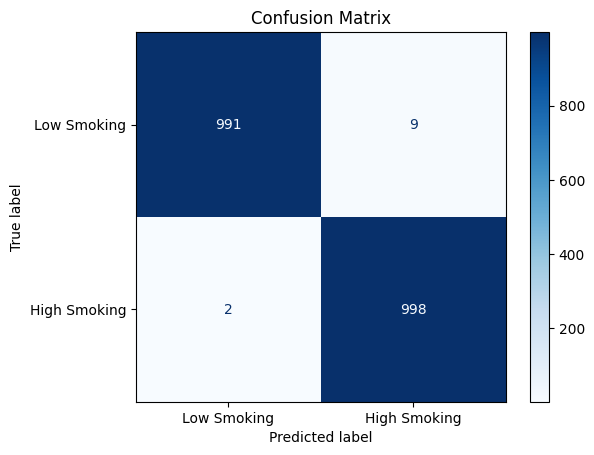

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Smoking", "High Smoking"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()



